# Data loading and exploration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

# File sizes
.DS_Store                     0.01MB
sample_submission.csv         22.35MB
test.csv                      314.02MB
train.csv                     63.4MB


In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('submission/naive_submission.csv', index=False)
sub.head()

Predicted score: 0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


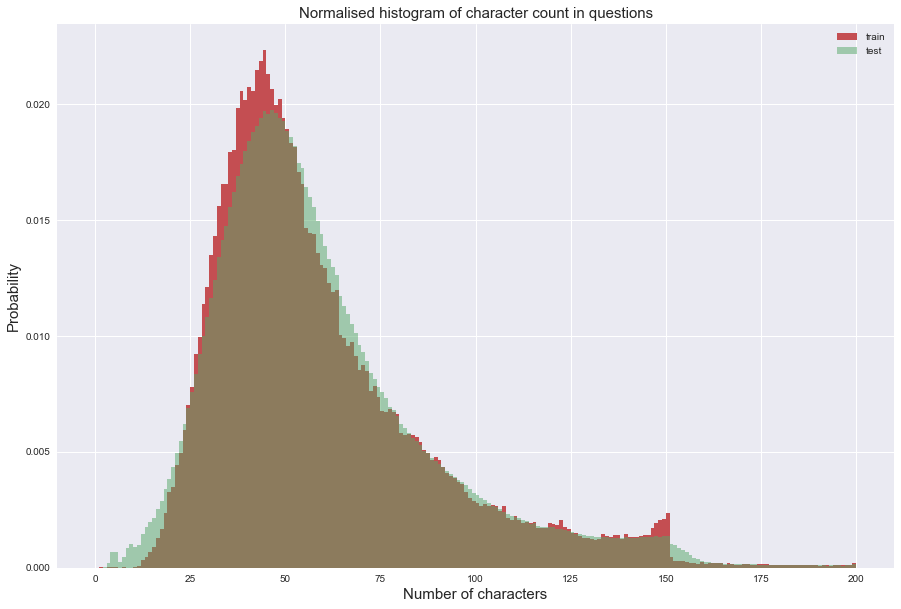

In [7]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


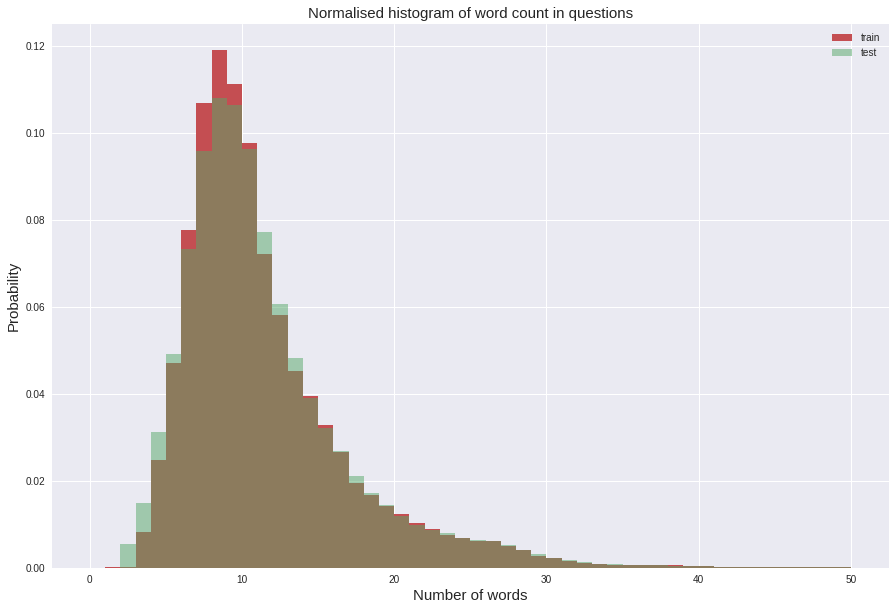

In [5]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

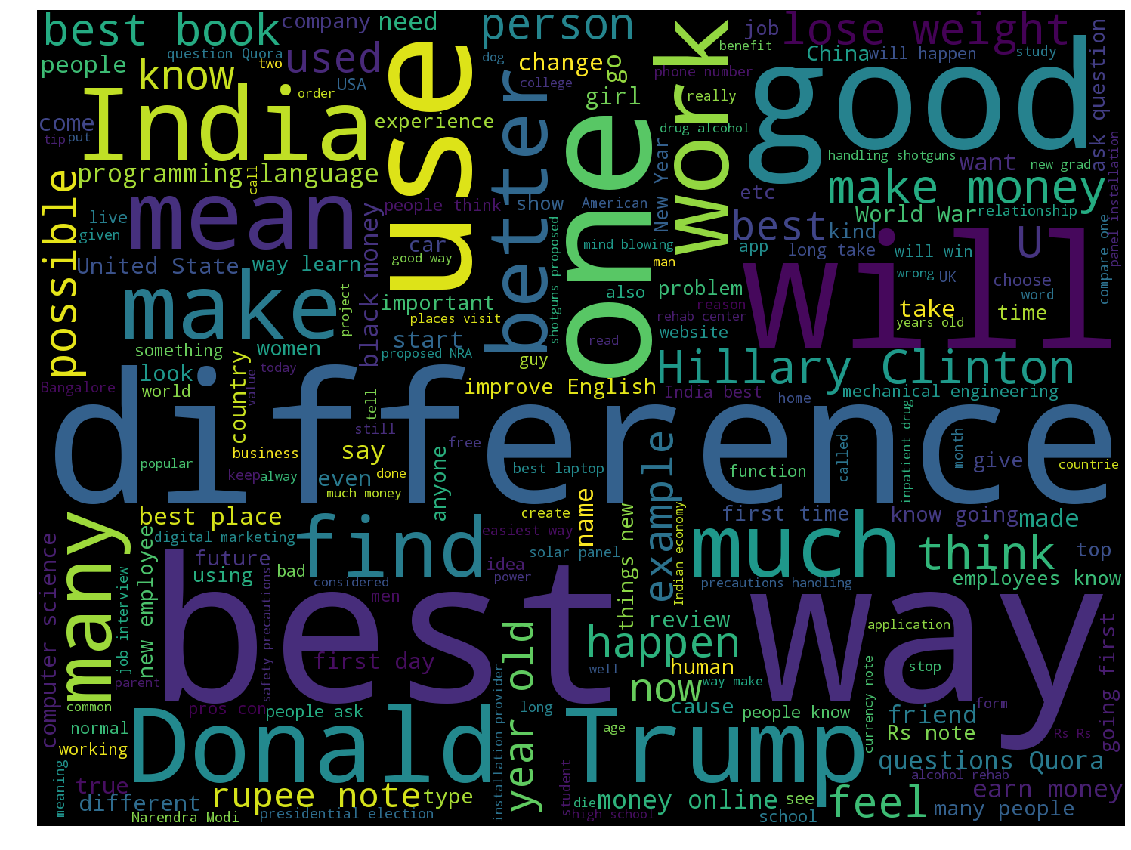

In [6]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [7]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


# Feature Engineering

## Question Length

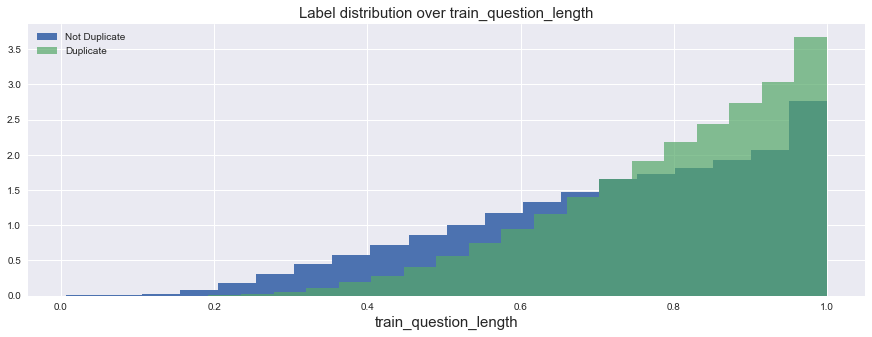

In [4]:
def question_length_compare(row):
    return min(len(str(row['question1'])), len(str(row['question2']))) / max(len(str(row['question1'])), len(str(row['question2'])))
train_question_length = df_train.apply(question_length_compare, axis=1, raw=True)


plt.figure(figsize=(15, 5))
plt.hist(train_question_length[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_question_length[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over train_question_length', fontsize=15)
plt.xlabel('train_question_length', fontsize=15)

## Word Match

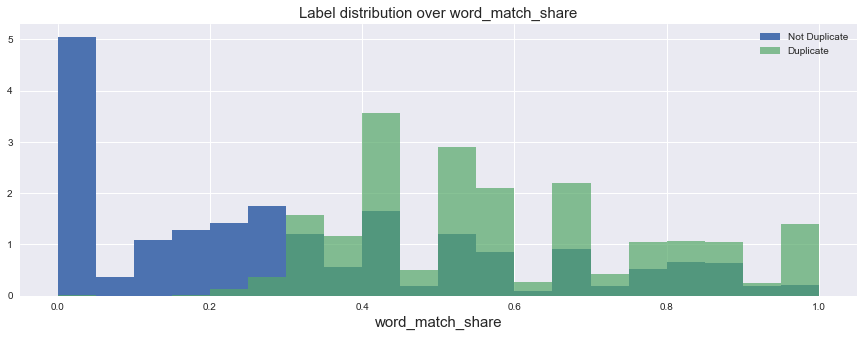

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

stops = set(stopwords.words("english"))
stemmer = SnowballStemmer('english')

def question_process(question, remove_punc=False, stem_words=False):
    word_dict = {}
    for word in str(question).lower().split():
        if word not in stops:
            if remove_punc:
                word = ''.join([c for c in word if c not in punctuation])
            if stem_words:
                word = stemmer.stem(word)
            word_dict[word] = word_dict.get(word, 0) + 1
    return word_dict

def word_match_share(row):
    q1words, q2words = question_process(row['question1']), question_process(row['question2'])
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words if w in q2words]
    shared_words_in_q2 = [w for w in q2words if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words.values()) + len(q2words.values()))
    return R

train_word_match = df_train.apply(word_match_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## Compute IDF

In [8]:
import math
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, min_count=2):
    if count < min_count:
        return 0
    else:
        return math.log(len(train_qs) / (count + 1))

words = [item for question in train_qs for item in set(str(question).lower().split())]
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [9]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 0.9759847565057325), ('what', 0.982481247126026), ('is', 1.1524016951763911), ('how', 1.3243207159193127), ('to', 1.503829461945385), ('in', 1.5164780422459685), ('a', 1.5194971893030818), ('i', 1.540480494674473), ('do', 1.6853445738105797), ('of', 1.7307720403399727)]

Least common words and weights: 


[('hears?', 12.504422613106469),
 ('shorte.st', 12.504422613106469),
 ('dd-wrt,', 12.504422613106469),
 ('newtonian?', 12.504422613106469),
 ('afrojack', 12.504422613106469),
 ('penalties?', 12.504422613106469),
 ('expansionary', 12.504422613106469),
 ('1961', 12.504422613106469),
 ('15-g', 12.504422613106469),
 ('roaring', 12.504422613106469)]

## TF-IDF Distance

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


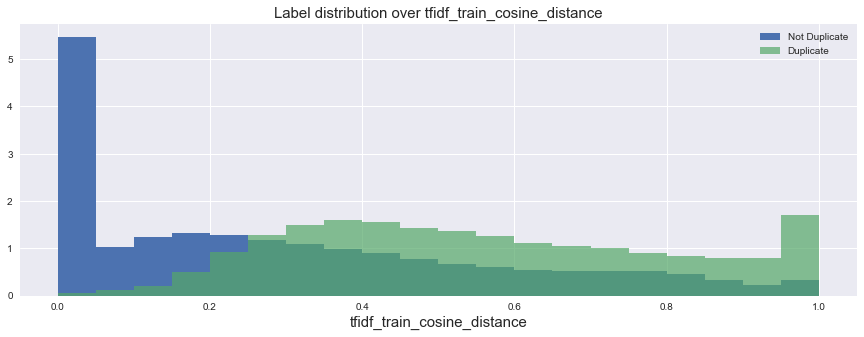

In [10]:
def tfidf_cosine_distance(row):
    q1words, q2words = question_process(row['question1']), question_process(row['question2'])
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    
    shared_words = [w for w in q1words.keys() if w in q2words.keys()]
    shared_weights = [weights.get(w, 0) for w in shared_words]

    Rcosine_denominator = (np.sqrt(np.dot(q1_weights, q1_weights)) * np.sqrt(np.dot(q2_weights, q2_weights)))
    return np.dot(shared_weights, shared_weights) / Rcosine_denominator

tfidf_train_cosine_distance = df_train.apply(tfidf_cosine_distance, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_cosine_distance[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_cosine_distance[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_train_cosine_distance', fontsize=15)
plt.xlabel('tfidf_train_cosine_distance', fontsize=15)

## Bigram Match

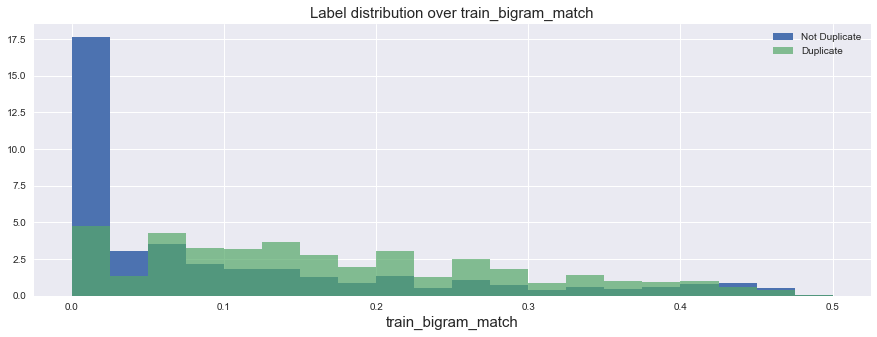

In [11]:
def bigram_match(row):
    q1_list = str(row['question1']).lower().split()
    q2_list = str(row['question2']).lower().split()
    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])
    shared_2gram = q1_2gram.intersection(q2_2gram)
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    return R2gram

train_bigram_match = df_train.apply(bigram_match, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_bigram_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(train_bigram_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over train_bigram_match', fontsize=15)
plt.xlabel('train_bigram_match', fontsize=15)

## TF-IDF Word Match

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


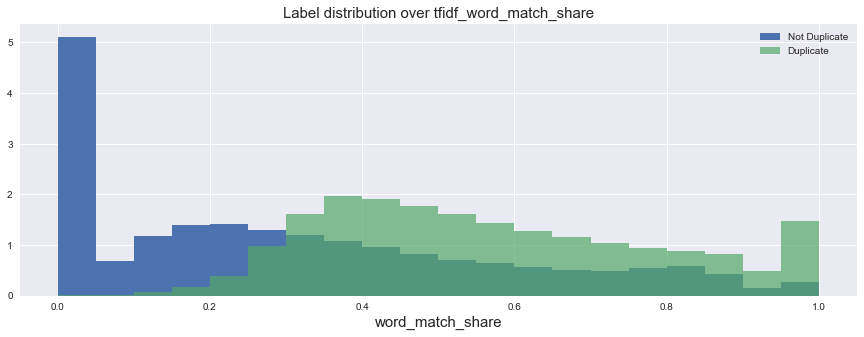

In [12]:
def tfidf_word_match_share(row):
    q1words, q2words = question_process(row['question1']), question_process(row['question2'])
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) * q1words[w] for w in q1words if w in q2words] + [weights.get(w, 0) * q2words[w] for w in q2words if w in q1words]
    total_weights = [weights.get(w, 0) * q1words[w] for w in q1words] + [weights.get(w, 0) * q2words[w] for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [65]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_cosine_distance.fillna(0)))

Original AUC: 0.780553200628
   TFIDF AUC: 0.763319747978


## Edit Distance

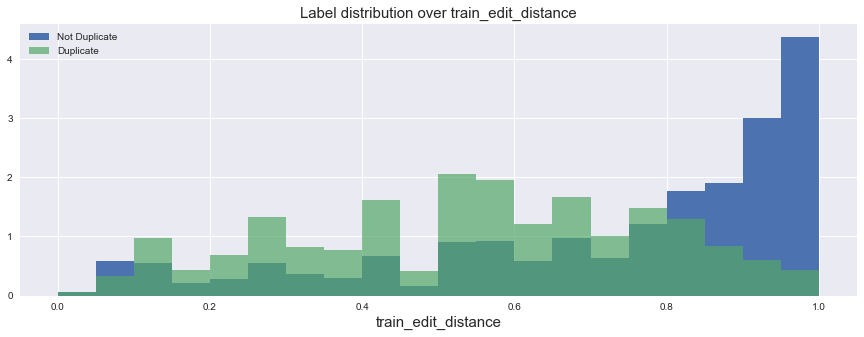

In [13]:
def question_edit_distance(row):
    word1 = str(row['question1']).lower().split()
    word2 = str(row['question2']).lower().split()

    matrix = [[0] * (len(word2) + 1) for i in range(len(word1) + 1)]
    for i in range(len(word2)):
        matrix[0][i + 1] = matrix[0][i] + 1
    for i in range(len(word1)):
        matrix[i + 1][0] = matrix[i][0] + 1
    for i in range(len(word1)):
        for j in range(len(word2)):
            matrix[i + 1][j + 1] = min(matrix[i][j + 1], matrix[i + 1][j]) + 1
            matrix[i + 1][j + 1] = min(matrix[i + 1][j + 1], 
                                       matrix[i][j] + (0 if word1[i] == word2[j] else 1))
    return matrix[len(word1)][len(word2)] / max(len(word1), len(word2))

train_edit_distance = df_train.apply(question_edit_distance, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_edit_distance[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_edit_distance[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over train_edit_distance', fontsize=15)
plt.xlabel('train_edit_distance', fontsize=15)

## Word2Vec Distance

In [25]:
from gensim.models import Word2Vec

word_data = [str(question).lower().split() for question in (train_qs + test_qs)]
word2vec = Word2Vec(word_data, size=100, window=5, min_count=5, workers=4)
word2vec.save('model/word2vec.bin')

NameError: name 'roc_auc_score' is not defined

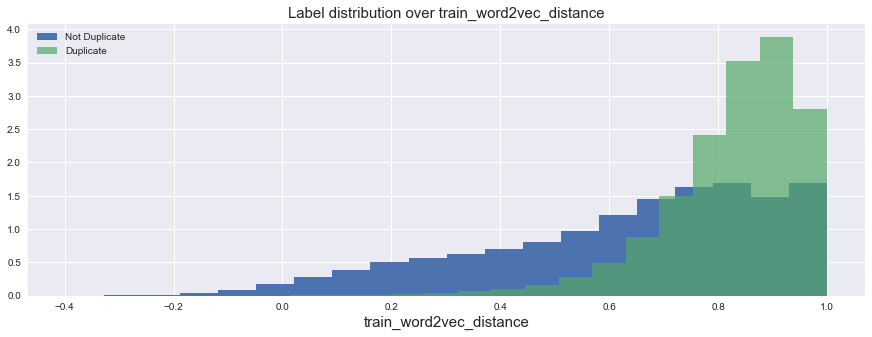

In [14]:
from gensim.models import Word2Vec
model = Word2Vec.load('model/word2vec.bin')

def cos_similarity(vector1, vector2):
    dotted = vector1.dot(vector2)
    vector1_norm = np.linalg.norm(vector1)
    vector2_norm = np.linalg.norm(vector2)
    vector_norms = np.multiply(vector1_norm, vector2_norm)
    neighbors = np.divide(dotted, vector_norms)
    return neighbors
    
def word2vec_similarity(row):
    question1 = np.array([model.wv[word] * weights.get(word, 0) for word in str(row['question1']).lower().split() if word in model.wv and word in weights])
    question2 = np.array([model.wv[word] * weights.get(word, 0) for word in str(row['question2']).lower().split() if word in model.wv and word in weights])
    if len(question1) == 0 or len(question2) == 0:
        return 0
    return cos_similarity(question1.mean(axis=0), question2.mean(axis=0))

train_word2vec_distance = df_train.apply(word2vec_similarity, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word2vec_distance[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word2vec_distance[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over train_word2vec_distance', fontsize=15)
plt.xlabel('train_word2vec_distance', fontsize=15)

## Question Frequency

In [16]:
df1 = df_train[['question1']].copy()
df2 = df_train[['question2']].copy()
df1_test = df_test[['question1']].copy()
df2_test = df_test[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True, drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = df_train.copy()
test_cp = df_test.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['q1_freq','q2_freq']]
test_comb = comb[comb['is_duplicate'] < 0][['q1_freq','q2_freq']]

## Question Word Coexist

In [15]:
def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [22]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_train['question_length'] = train_question_length
x_train['edit_distance'] = train_edit_distance
x_train['word2vec_distance'] = train_word2vec_distance
x_train['sqrt_word_match'] = np.sqrt(train_word_match)
x_train['bigram_match'] = train_bigram_match
x_train['tfidf_cosine_distance'] = tfidf_train_cosine_distance
x_train['q1_freq'] = train_comb['q1_freq']
x_train['q2_freq'] = train_comb['q2_freq']

add_word_count(x_train, df_train, 'how')
add_word_count(x_train, df_train, 'what')
add_word_count(x_train, df_train, 'which')
add_word_count(x_train, df_train, 'who')
add_word_count(x_train, df_train, 'where')
add_word_count(x_train, df_train, 'when')
add_word_count(x_train, df_train, 'why')

x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
x_test['question_length'] = df_test.apply(question_length_compare, axis=1, raw=True)
x_test['edit_distance'] = df_test.apply(question_edit_distance, axis=1, raw=True)
x_test['word2vec_distance'] = df_test.apply(word2vec_similarity, axis=1, raw=True)
x_test['sqrt_word_match'] = np.sqrt(x_test['word_match'])
x_test['bigram_match'] = df_test.apply(bigram_match, axis=1, raw=True)
x_test['tfidf_cosine_distance'] = df_test.apply(tfidf_cosine_distance, axis=1, raw=True)
x_test['q1_freq'] = test_comb['q1_freq']
x_test['q2_freq'] = test_comb['q2_freq']

add_word_count(x_test, df_test, 'how')
add_word_count(x_test, df_test, 'what')
add_word_count(x_test, df_test, 'which')
add_word_count(x_test, df_test, 'who')
add_word_count(x_test, df_test, 'where')
add_word_count(x_test, df_test, 'when')
add_word_count(x_test, df_test, 'why')

y_train = df_train['is_duplicate'].values

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [18]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
neg_needed = int(len(pos_train) / p) - (len(pos_train) + len(neg_train))
neg_sample = neg_train.sample(n = neg_needed, replace = True)
neg_train = pd.concat([neg_train, neg_sample])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.16500004421726597


In [19]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 600, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.625717	valid-logloss:0.625778
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.347062	valid-logloss:0.347918
[20]	train-logloss:0.2805	valid-logloss:0.28166
[30]	train-logloss:0.261059	valid-logloss:0.262286
[40]	train-logloss:0.253167	valid-logloss:0.254571
[50]	train-logloss:0.249751	valid-logloss:0.251278
[60]	train-logloss:0.247162	valid-logloss:0.248857
[70]	train-logloss:0.244997	valid-logloss:0.246894
[80]	train-logloss:0.24306	valid-logloss:0.245108
[90]	train-logloss:0.2417	valid-logloss:0.243969
[100]	train-logloss:0.240449	valid-logloss:0.242897
[110]	train-logloss:0.239657	valid-logloss:0.242238
[120]	train-logloss:0.238548	valid-logloss:0.24128
[130]	train-logloss:0.236986	valid-logloss:0.23993
[140]	train-logloss:0.236313	valid-logloss:0.2395
[150]	train-logloss:0.235611	valid-logloss:0.238998
[160]	train-logloss:0.234889	valid-log

In [23]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('submission/q_freq_xgb.csv', index=False)